<a href="https://colab.research.google.com/github/polina-minaeva/text-tonality-classification/blob/main/%D0%A2%D0%B5%D0%BC%D0%B0%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B8_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F_%D0%BE%D1%82%D0%B7%D1%8B%D0%B2%D0%BE%D0%B2_%D0%BD%D0%B0_%D0%B1%D0%B0%D0%BD%D0%BA%D0%B8_2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Часть 1. Анализ текстов

Загрузка библиотек

In [1]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [2]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
nltk.download('stopwords')
stopw = stopwords.words('russian')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
from collections import Counter
import itertools

In [5]:
from pymystem3 import Mystem
m = Mystem()

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [6]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim import similarities

Загрузка данных, то есть отзывов на банки от клиентов из разных городов

In [ ]:
'''Подключаемся к гугл диску'''

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
filet = 'drive/MyDrive/Colab Notebooks/banki_responses.json.bz2'
filet

'drive/MyDrive/Colab Notebooks/banki_responses.json.bz2'

In [8]:
responses = []
with bz2.BZ2File(filet, 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [01:19, 2523.59it/s]


In [ ]:
#responses[62]['city']

'г. Волгоград'

In [ ]:
#responses[62]['bank_name']

In [ ]:
#для удобства расчетов нужно создать список, где перечислим все города из каждого отзыва

cities = []

for client in responses:
  cities.append(client['city'])

cities[:10]

['г. Москва',
 'г. Новосибирск',
 'г. Москва',
 'г. Ставрополь',
 'г. Челябинск',
 'г. Москва',
 'г. Волгоград',
 'г. Москва',
 'г. Пермь',
 'г. Ростов-на-Дону']

In [ ]:
#далее с помощью класса Counter посчитаем число вхождений каждого города в список

cities_resp = Counter(cities)
cities_resp

Counter({'г. Москва': 55354,
         'г. Новосибирск': 2300,
         'г. Ставрополь': 696,
         'г. Челябинск': 1507,
         'г. Волгоград': 1014,
         'г. Пермь': 1163,
         'г. Ростов-на-Дону': 1891,
         'г. Воронеж': 1210,
         'г. Таганрог (Ростовская обл.)': 8,
         'г. Санкт-Петербург': 14342,
         'г. Конаково': 9,
         'г. Мурманск': 434,
         'г. Волгодонск (Ростовская обл.)': 7,
         'г. Большеречье': 2,
         'г. Одинцово (Московская обл.)': 8,
         'г. Салават (Республика Башкортостан)': 4,
         'г. Краснодар': 1262,
         'г. Кострома': 160,
         'г. Нижний Новгород': 1976,
         'г. Орел': 234,
         'г. Саратов': 933,
         'г. Казань': 1440,
         'г. Реутов (Московская обл.)': 3,
         'г. Ульяновск': 500,
         'г. Красноярск': 1236,
         'г. Хабаровск': 681,
         'г. Магнитогорск (Челябинская обл.)': 16,
         'г. Фролово (Волгоградская обл.)': 1,
         'г. Новочеркасск': 6

Количество отзывов по городам равно числу вхождений этих городов в список cities

In [ ]:
#аналогичным образом найдем количество отзывов по банкам

banks = []

for client in responses:
  banks.append(client['bank_name'])

banks_resp = Counter(banks)
banks_resp

Counter({'Бинбанк': 1646,
         'Сбербанк России': 26327,
         'ОТП Банк': 3237,
         'Гагаринский': 19,
         'Тинькофф Банк': 5387,
         'Восточный Экспресс Банк': 3138,
         'ВТБ 24': 8185,
         'Альфа-Банк': 10224,
         'БИНБАНК кредитные карты': 1464,
         'МТС Банк': 1870,
         'Совкомбанк': 919,
         'Россельхозбанк': 532,
         'Московский Кредитный Банк': 2944,
         'МДМ Банк': 776,
         'Хоум Кредит Банк': 7549,
         'Бенифит-Банк': 115,
         'Уральский Банк Реконструкции и Развития': 532,
         'Русский Стандарт': 7943,
         'Лето Банк': 501,
         'Петрокоммерц': 339,
         'Русфинанс Банк': 723,
         'Киви Банк': 1741,
         'Ханты-Мансийский банк Открытие': 2158,
         'Русславбанк': 715,
         'Татфондбанк': 159,
         'МАСТ-Банк': 208,
         'Национальный Банк «Траст»': 4607,
         'Военно-Промышленный Банк': 149,
         'АктивКапитал Банк': 75,
         'Связной Банк': 377

Далее нужно построить гистограмму длин отзывов в словах и символах. Для этого используем регулярные выражения и библиотеку Seaborn для визуализаций

In [ ]:
#t50 = responses[50]['text']
#t50

'Добрый день, хочу написать свой отзыв о работе банка. Мне пришлось столкнуться с неприятностью. Выплатив кредит полностью, я явилась в офис банка в г. Ростов-на- Дону, ул.Театральная 60., получила на руки справку о погашении задолжености, следующим шагом моим было изъявление желания о закрытии счета, но оказалось, что на счете имеется переплата в 90 копеек,я написала заявление о зачислении денег на счет банка, для того чтобы наконец то получить справку о закрытии моего счета, это было 22 мая 2015 года, 08.06.2015г. мной был сделан звонок в банк с целью выяснения, почему так долго списывается сумма в 90 копеек с моего счета и когда же наконец я его закрою, на что был получен ответ, что 90 копеек там еще до сих пор висят,  сколько можно ждать, простой формальной процедуры?почему я, клиент банка, который не сделал ни одной просрочки в платежах в течении года,должна ждать, тратить свои деньги на звонки в банк, поездки туда, проживаю я в Новочеркасске,  и испытывать стресс!!!!'

In [ ]:
#text = re.findall('[a-zа-яё]+', t50, flags=re.IGNORECASE)

#print(text)

['Добрый', 'день', 'хочу', 'написать', 'свой', 'отзыв', 'о', 'работе', 'банка', 'Мне', 'пришлось', 'столкнуться', 'с', 'неприятностью', 'Выплатив', 'кредит', 'полностью', 'я', 'явилась', 'в', 'офис', 'банка', 'в', 'г', 'Ростов', 'на', 'Дону', 'ул', 'Театральная', 'получила', 'на', 'руки', 'справку', 'о', 'погашении', 'задолжености', 'следующим', 'шагом', 'моим', 'было', 'изъявление', 'желания', 'о', 'закрытии', 'счета', 'но', 'оказалось', 'что', 'на', 'счете', 'имеется', 'переплата', 'в', 'копеек', 'я', 'написала', 'заявление', 'о', 'зачислении', 'денег', 'на', 'счет', 'банка', 'для', 'того', 'чтобы', 'наконец', 'то', 'получить', 'справку', 'о', 'закрытии', 'моего', 'счета', 'это', 'было', 'мая', 'года', 'г', 'мной', 'был', 'сделан', 'звонок', 'в', 'банк', 'с', 'целью', 'выяснения', 'почему', 'так', 'долго', 'списывается', 'сумма', 'в', 'копеек', 'с', 'моего', 'счета', 'и', 'когда', 'же', 'наконец', 'я', 'его', 'закрою', 'на', 'что', 'был', 'получен', 'ответ', 'что', 'копеек', 'там', '

In [ ]:
#len(text)

157

In [ ]:
#text2 = re.findall('\w+', t50)
#print(text2)

['Добрый', 'день', 'хочу', 'написать', 'свой', 'отзыв', 'о', 'работе', 'банка', 'Мне', 'пришлось', 'столкнуться', 'с', 'неприятностью', 'Выплатив', 'кредит', 'полностью', 'я', 'явилась', 'в', 'офис', 'банка', 'в', 'г', 'Ростов', 'на', 'Дону', 'ул', 'Театральная', '60', 'получила', 'на', 'руки', 'справку', 'о', 'погашении', 'задолжености', 'следующим', 'шагом', 'моим', 'было', 'изъявление', 'желания', 'о', 'закрытии', 'счета', 'но', 'оказалось', 'что', 'на', 'счете', 'имеется', 'переплата', 'в', '90', 'копеек', 'я', 'написала', 'заявление', 'о', 'зачислении', 'денег', 'на', 'счет', 'банка', 'для', 'того', 'чтобы', 'наконец', 'то', 'получить', 'справку', 'о', 'закрытии', 'моего', 'счета', 'это', 'было', '22', 'мая', '2015', 'года', '08', '06', '2015г', 'мной', 'был', 'сделан', 'звонок', 'в', 'банк', 'с', 'целью', 'выяснения', 'почему', 'так', 'долго', 'списывается', 'сумма', 'в', '90', 'копеек', 'с', 'моего', 'счета', 'и', 'когда', 'же', 'наконец', 'я', 'его', 'закрою', 'на', 'что', 'был

In [ ]:
hist_words = []

for client in responses:
  resp = re.findall('[a-zа-яё]+', client['text'], flags=re.IGNORECASE)
  hist_words.append(len(resp))

In [ ]:
#hist_words[:10]

[213, 135, 83, 121, 291, 79, 84, 98, 95, 194]

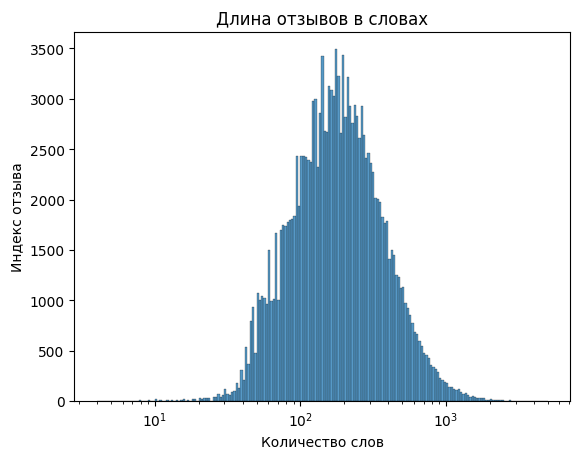

In [ ]:
sns.histplot(data=hist_words, log_scale=True).set(title='Длина отзывов в словах', xlabel='Количество слов', ylabel='Индекс отзыва')
plt.show()

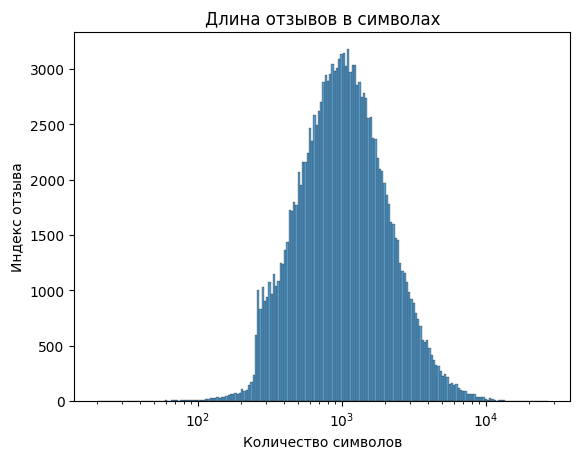

In [ ]:
hist_sym = []

for person in responses:
    person_text = person['text'].replace(' ', '')
    hist_sym.append(len(person_text))

sns.histplot(data=hist_sym, log_scale=True).set(title='Длина отзывов в символах', xlabel='Количество символов', ylabel='Индекс отзыва')
plt.show()

## 10 самых частых слов в отзывах

In [ ]:
#for man in responses:
#  resp = re.findall('[a-zа-яё]+', man['text'], flags=re.IGNORECASE)

In [ ]:
'''Найдем все слова в текстах'''

all_texts = []

for man in responses:
  resp = re.findall('[a-zа-яё]+', man['text'], flags=re.IGNORECASE)
  all_texts.append(resp)

len(all_texts) #количество отзывов

#all_texts = sum(all_texts, [])
#Counter(all_texts).most_common(10)

153499

In [ ]:
all_texts[:2]

[['Добрый',
  'день',
  'Я',
  'не',
  'являюсь',
  'клиентом',
  'банка',
  'и',
  'поручителем',
  'по',
  'кредитному',
  'договору',
  'а',
  'также',
  'не',
  'являюсь',
  'каким',
  'либо',
  'другим',
  'лицом',
  'письменно',
  'оформившим',
  'отношения',
  'с',
  'банком',
  'по',
  'поводу',
  'урегулирования',
  'чьей',
  'либо',
  'задолженности',
  'Начиная',
  'с',
  'марта',
  'года',
  'начали',
  'приходить',
  'бесконечные',
  'письма',
  'из',
  'ООО',
  'Примо',
  'коллект',
  'на',
  'мой',
  'адрес',
  'город',
  'Москва',
  'Уваровский',
  'переулок',
  'дом',
  'квартира',
  'с',
  'угрозами',
  'о',
  'возбуждении',
  'уголовного',
  'дела',
  'в',
  'отношении',
  'гражданина',
  'Филиппова',
  'Эдуарда',
  'Владимировича',
  'который',
  'уклоняется',
  'от',
  'уплаты',
  'взятых',
  'им',
  'кредитов',
  'договор',
  'от',
  'года',
  'и',
  'договор',
  'от',
  'года',
  'Со',
  'всей',
  'ответственностью',
  'хочу',
  'Вас',
  'заверить',
  'что',
  'в

In [ ]:
import itertools

result = list(itertools.chain(*all_texts)) #создаем один список из набора списков
result[:10]

['Добрый',
 'день',
 'Я',
 'не',
 'являюсь',
 'клиентом',
 'банка',
 'и',
 'поручителем',
 'по']

In [ ]:
resultl = [res.lower() for res in result]
resultl[:10] #все слова в низком регистре

['добрый',
 'день',
 'я',
 'не',
 'являюсь',
 'клиентом',
 'банка',
 'и',
 'поручителем',
 'по']

In [ ]:
Counter(resultl).most_common(10) #самые частые слова

[('в', 1330292),
 ('и', 1058982),
 ('не', 852429),
 ('на', 707799),
 ('что', 640057),
 ('я', 577484),
 ('с', 462744),
 ('по', 372755),
 ('мне', 320958),
 ('банка', 275899)]

## 10 самых частых слов в отзывах (не учитывая стоп-слова)

In [ ]:
res_clean = [] #список для будущего ответа

for elem in resultl:
  if elem not in stopw:
    res_clean.append(elem)

res_clean[:10] #список слов без стоп-слов

['добрый',
 'день',
 'являюсь',
 'клиентом',
 'банка',
 'поручителем',
 'кредитному',
 'договору',
 'также',
 'являюсь']

Результат: пропала частица не

In [ ]:
Counter(res_clean).most_common(10) #самые частые слова (не учитывая стоп-слов)

[('банка', 275899),
 ('банк', 215410),
 ('это', 183365),
 ('деньги', 131200),
 ('карту', 105827),
 ('карты', 101821),
 ('кредит', 81118),
 ('день', 76552),
 ('т', 75720),
 ('банке', 72162)]

## 10 самых частых существительных

In [ ]:
pip install pymorphy2

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 69.2 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13704 sha256=e7c4c76824e09c4746e46ce5a54c1a69faf94d8eebe684e897d9434f5421f2e1
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [ ]:
from pymorphy2 import MorphAnalyzer

In [ ]:
morph = MorphAnalyzer()

In [ ]:
noun_all = [] #список для будущего ответа

for word in res_clean:
  word_anali = morph.parse(word)[0]
  if 'NOUN' in word_anali.tag:
    noun_all.append(word)

noun_all[:10] #список существительных

['день',
 'клиентом',
 'банка',
 'поручителем',
 'договору',
 'лицом',
 'отношения',
 'банком',
 'поводу',
 'урегулирования']

In [ ]:
Counter(noun_all).most_common(10) #самые частые существительные

[('банка', 275899),
 ('банк', 215410),
 ('деньги', 131200),
 ('карту', 105827),
 ('карты', 101821),
 ('кредит', 81118),
 ('день', 76552),
 ('банке', 72162),
 ('заявление', 70423),
 ('отделение', 66647)]

СДЕЛАТЬ САМЫЕ ЧАСТЫЕ СУЩЕСТВИТЕЛЬНЫЕ ИЗ ЛЕММ

## 4. Кривые Ципфа и Хипса

Кривая Ципфа: частотность слов убывает очень быстро

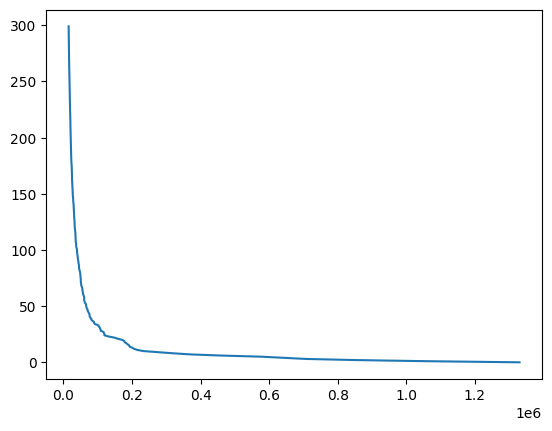

In [ ]:
freqs = list(Counter(resultl).values()) #счетчик слов
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()

Кривая Хипса: чем больше корпус, тем меньше новых слов добавляется с добавлением новых текстов

In [9]:
def heaps_curve(text):
    corpus = []
    vocab_sizes = []
    words_seen = set()
    for word in text:
        words_seen.add(word)
        corpus.append(len(words_seen))
        vocab_sizes.append(len(words_seen))
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(corpus)), vocab_sizes, marker='o', linestyle='-')
    plt.title('Кривая Хипса')
    plt.xlabel('Размер корпуса')
    plt.ylabel('Размер словаря')
    plt.show()

In [ ]:
heaps_curve(tokens)

## 5. Поиск слов

In [ ]:
c = Counter(noun_all)
c['сотрудник'] < c['клиент']

False

In [ ]:
c['мошенничество']

1106

In [ ]:
c['доверие']

1156

## 6. Ключевые слова и биграмы

In [ ]:
for client in responses:
  if client[index]['rating_grade'] = 5

## 10 самых частых лемм

In [ ]:
words_low = [[word.lower() for word in resp] for resp in all_texts[:10001]]
words_low[:2]

[['добрый',
  'день',
  'я',
  'не',
  'являюсь',
  'клиентом',
  'банка',
  'и',
  'поручителем',
  'по',
  'кредитному',
  'договору',
  'а',
  'также',
  'не',
  'являюсь',
  'каким',
  'либо',
  'другим',
  'лицом',
  'письменно',
  'оформившим',
  'отношения',
  'с',
  'банком',
  'по',
  'поводу',
  'урегулирования',
  'чьей',
  'либо',
  'задолженности',
  'начиная',
  'с',
  'марта',
  'года',
  'начали',
  'приходить',
  'бесконечные',
  'письма',
  'из',
  'ооо',
  'примо',
  'коллект',
  'на',
  'мой',
  'адрес',
  'город',
  'москва',
  'уваровский',
  'переулок',
  'дом',
  'квартира',
  'с',
  'угрозами',
  'о',
  'возбуждении',
  'уголовного',
  'дела',
  'в',
  'отношении',
  'гражданина',
  'филиппова',
  'эдуарда',
  'владимировича',
  'который',
  'уклоняется',
  'от',
  'уплаты',
  'взятых',
  'им',
  'кредитов',
  'договор',
  'от',
  'года',
  'и',
  'договор',
  'от',
  'года',
  'со',
  'всей',
  'ответственностью',
  'хочу',
  'вас',
  'заверить',
  'что',
  'в

In [ ]:
lem_all = [[m.lemmatize(word)[0] for word in resp] for resp in words_low]
lem_all[:5]

[['добрый',
  'день',
  'я',
  'не',
  'являться',
  'клиент',
  'банка',
  'и',
  'поручитель',
  'по',
  'кредитный',
  'договор',
  'а',
  'также',
  'не',
  'являться',
  'какой',
  'либо',
  'другой',
  'лицо',
  'письменно',
  'оформлять',
  'отношение',
  'с',
  'банк',
  'по',
  'повод',
  'урегулирование',
  'чей',
  'либо',
  'задолженность',
  'начинать',
  'с',
  'март',
  'год',
  'начинать',
  'приходить',
  'бесконечный',
  'письмо',
  'из',
  'ооо',
  'примо',
  'коллект',
  'на',
  'мой',
  'адрес',
  'город',
  'москва',
  'уваровский',
  'переулок',
  'дом',
  'квартира',
  'с',
  'угроза',
  'о',
  'возбуждение',
  'уголовный',
  'дело',
  'в',
  'отношение',
  'гражданин',
  'филиппов',
  'эдуард',
  'владимирович',
  'который',
  'уклоняться',
  'от',
  'уплата',
  'взять',
  'они',
  'кредит',
  'договор',
  'от',
  'год',
  'и',
  'договор',
  'от',
  'год',
  'со',
  'весь',
  'ответственность',
  'хотеть',
  'вы',
  'заверять',
  'что',
  'вышеуказанный',
  'г

In [ ]:
lems = list(itertools.chain(*lem_all))

In [ ]:
lem_clean = [] #список для будущего ответа

for elem in lems:
  if elem not in stopw:
    lem_clean.append(elem)

lem_clean[:10] #список лемм без стоп-слов

['добрый',
 'день',
 'являться',
 'клиент',
 'банка',
 'поручитель',
 'кредитный',
 'договор',
 'также',
 'являться']

In [ ]:
Counter(lem_clean).most_common(10) #самые частые леммы

[('банк', 22781),
 ('банка', 19041),
 ('карта', 18949),
 ('это', 17653),
 ('день', 10075),
 ('кредит', 9776),
 ('деньги', 9582),
 ('сотрудник', 9375),
 ('который', 9099),
 ('клиент', 7981)]

#Часть 2. Тематическое моделирование

In [ ]:
lem_clean = [] #список для будущего ответа

for elem in lem_all:
  for word in elem:
    if word not in stopw:
      lem_clean.append(elem)

lem_clean[:10] #список лемм без стоп-слов

In [ ]:
dictionary = Dictionary(lem_clean)
corpus = [dictionary.doc2bow(text) for text in lem_clean]

TypeError: doc2bow expects an array of unicode tokens on input, not a single string